# Summary of Approach Taken in Modelling

After the data exploration and preprocessing parts, we've looked into finding a model that predicts a customer's tendency to not renew a contract (churn) sufficiently well. For this we have tested multiple classification models (various methods along with tuning hyperparameters based on classification error), and finally chosen one based on a list of criteria. 

The training was conducted on 60% of the data, and testing was ultimately done to generate scores on the remaining 40% of the data.

# Import Libraries and Load Data

### Define Warning Blocker 

An initial blocker function was defined to block unnecessary warnings on the models. This is after the models were checked for any potential issues, to clean up the notebook.

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, log_loss, auc
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE

In [4]:
from sklearn.linear_model import LogisticRegression 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

### Load Data

Two data sets were previously created with a split based on training and final testing. Both are loaded below.

In [5]:
df = pd.read_csv("telco_train.csv", index_col=0)
df_test = pd.read_csv("telco_test.csv", index_col=0)

## Feature Selection and Engineering

A few additional columns are added, that might assist the model in predicting the churn

In [6]:
df.head(10)

,gender,senior,partner,dependents,tenure,phone,multiple_lines,online_security,online_backup,device_protection,...,monthly_charges,total_charges,internet_dsl,internet_fiber,contract_1_yr,contract_2_yr,payment_credit_card,payment_electronic_check,payment_mailed_check,churn
2142,0,0,0,1,21,1,0,1,0,1,...,64.85,1336.80,1,0,1,0,0,0,1,0
1623,0,0,0,0,54,1,1,0,1,0,...,97.20,5129.45,0,1,0,1,0,0,0,0
6074,1,0,1,0,1,0,0,0,0,0,...,23.45,23.45,1,0,0,0,0,1,0,1
1362,1,0,0,0,4,1,0,0,0,0,...,70.20,237.95,0,1,0,0,0,1,0,1
6754,1,0,0,1,0,1,1,1,1,0,...,61.90,0.00,1,0,0,1,0,0,0,0
1212,1,0,0,0,7,1,0,0,0,0,...,69.55,521.35,0,1,0,0,0,1,0,0
2722,1,0,1,1,32,1,0,0,0,0,...,18.95,613.95,0,0,0,1,0,0,1,0
4006,1,0,1,1,72,1,0,0,0,0,...,19.80,1414.65,0,0,0,1,1,0,0,0
6791,1,0,0,0,19,0,0,0,0,1,...,39.65,733.35,1,0,0,0,0,1,0,1
5466,1,0,0,1,10,1,0,0,0,0,...,19.95,219.50,0,0,1,0,0,0,0,0


In [7]:
df.columns

Index(['gender', 'senior', 'partner', 'dependents', 'tenure', 'phone',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'internet_dsl',
       'internet_fiber', 'contract_1_yr', 'contract_2_yr',
       'payment_credit_card', 'payment_electronic_check',
       'payment_mailed_check', 'churn'],
      dtype='object')

In [8]:
# Adding Feature for average charges by tenure
df["average_charges"] = df.apply(lambda x: 0.0 if int(x["tenure"])==0 else x["total_charges"]/float(x["tenure"]), axis=1)
df_test["average_charges"] = df_test.apply(lambda x: 0.0 if int(x["tenure"])==0 else x["total_charges"]/float(x["tenure"]), axis=1)

# Adding Feature for whether the customer is a single parent
df["single_parent"] = df.apply(lambda x: 1 if (int(x['partner'])==0 and int(x['dependents'])!=0) else 0, axis=1)
df_test["single_parent"] = df_test.apply(lambda x: 1 if (int(x['partner'])==0 and int(x['dependents'])!=0) else 0, axis=1)

# Adding Feature for whether the customer is a senior without immediate family
df["lonely_senior"] = df.apply(lambda x: 1 if (int(x['partner'])==0 and int(x['dependents'])==0 and int(x['senior'])==1) else 0, axis=1)
df_test["lonely_senior"] = df_test.apply(lambda x: 1 if (int(x['partner'])==0 and int(x['dependents'])==0 and int(x['senior'])==1) else 0, axis=1)

# Adding Feature for whether the customer is a repeat renewer (has renewed monthly for over 12 months)
df["repeat_renewer"] = df.apply(lambda x: 1 if (int(x['tenure'])>12 and int(x['contract_1_yr'])==0 and int(x['contract_2_yr'])==0) else 0, axis=1)
df_test["repeat_renewer"] = df_test.apply(lambda x: 1 if (int(x['tenure'])>12 and int(x['contract_1_yr'])==0 and int(x['contract_2_yr'])==0) else 0, axis=1)

# Adding Feature for total count of family members for the customer, using and sharing services
df["total_fam"] = df.apply(lambda x: int(x['partner']) + int(x['dependents']) + 1, axis=1)
df_test["total_fam"] = df_test.apply(lambda x: int(x['partner']) + int(x['dependents']) + 1, axis=1)



#### The 5 additional variables added to improve prediction are -

Average Charges - This variable indicates the total charges incurred by the customer divided by the tenure. This captures the prior payments made in different contract types (prior payments on a monthly basis would be captured to be higher than those made in a yearly basis)

Single Parent - This is to specifically segment out single parents, with dependents but no partner. We believe this might have an impact on the prediction

Lonely Senior - Similar to the previous variable, this is to segment out seniors who have no partner or dependents, added for potential segmentation of customers

Repeat Renewer - This captures customers who renew on a monthly basis and have a tenure of more than 12 months. It could indicate a customer who is willing to leave the plan on a short notice.

Total Family - The total count of family members represented by the customer, including themselves

### Edit the Datasets to Preprocess

In [9]:
X = df.drop(["churn"], axis=1)
y = df.churn.reset_index().churn

X_test = df_test.drop(["churn"], axis=1)
y_test = df_test.churn.reset_index().churn

In [10]:
X = X.astype(np.float64)
X_test = X_test.astype(np.float64)
Xu = X.values
Xu_test = X_test.values

### Scale the Dataset

Scaling the dataset adjusts for variables in the data being very different in the range of values. By scaling or normalization, this brings the relative magnitudes to be the same across all features. 

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.fit_transform(X_test)

### Split for Cross Validation

Cross Validation will be used in all models to determine the cross-validation error and other metrics, which will be a proxy for the generalization error on real life data. The selection of hyper-parameters specific to each model will be based on this cross-validation error. Since there will be a tendency of the model to overfit on the training data, the metrics calculated by cross validation will better assess the model performance on external data.

In [12]:
kf = KFold(n_splits=10)
kf.get_n_splits(X)
print(kf)

KFold(n_splits=10, random_state=None, shuffle=False)


### Estimation of Null Accuracy

Prior to Running models, we can set a baseline by calculating the null accuracy. Every model must perform better than simply guessing based on the value that appears more frequently in the data.

In [13]:
print("The Null Accuracy of Churn Prediction: %0.3f" % (1-np.mean(y)))

The Null Accuracy of Churn Prediction: 0.734


In this case, the null accuracy in the training data is 0.734, therefore every model must perform better than this accuracy. Since the null accuracy is so high, the data is taken to be skewed, and other metrics like the F1 score and the ROC-AUC score have to be taken into account for model assessment.

# Metrics for Model Assessment

**Prediction Accuracy** - We will be using the prediction accuracy as one of the central metrics to assess models. This will simply be computed as the fraction of observations correctly classified by the algorithm. However, since the data is skewed and the null accuracy is observed to be so high, the classifier will have to do much better than this. If the results of the models aren't a stark improvement on the null accuracy, we will have to depend on other metrics to evaluate the performance of our models.

**F1 Score** - The F1 score is the weighted average of the precision and the recall. The precision of a classifier is the ratio of correctly predicted positive observations vs the total predicted positive observations, and the recall is the ratio of correctly predicted positive observations to all true positive observations. This basically assesses how well the model is working with the churn with respect to which we have calculated the precision and recall.

**ROC AUC Score** - The area under the curve of the receiver operator charateristic plot of the model is taken into account as a good indicator of the model's performance, even in the case of the data being skewed in one direction. While this skew affects the accuracy of the class prediction, the ROC AUC score will still be a valid metric. 

Given the three metrics we have just seen, we will tune our hyper-parameters on the basis of accuracy, but the final decision on the model will be made by looking at all three scores, and weighing the F1 and ROC-AUC score with higher priority

# Testing Different Models

## Logistic Regression Models

### Simple Logistic Regression

First step involves looking at the performance of a simple logistic regression classifier. This is a stepping stone to moving to penalized models, to reduce the risk of overfitting. 

In [14]:
logreg_basic = LogisticRegression(solver="lbfgs", random_state=0)
logreg_basic.fit(X, y)
print("Accuracy of Logistic Regression on training set: {:.3f}".format(logreg_basic.score(X, y)))

# Cross Validation Score

gen_error_lrb = list()
f1_lrb = list()
ra_lrb = list()

for train_index, test_index in kf.split(X):
    logreg_basic_gen = LogisticRegression(solver="lbfgs", random_state=0)
    logreg_basic_gen.fit(X[train_index], y[train_index])
    gen_error_lrb.append(logreg_basic_gen.score(X[test_index], y[test_index]))
    y_pred = logreg_basic_gen.predict(X[test_index])
    f1_lrb.append(f1_score(y[test_index],y_pred))
    ra_lrb.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross-Validation Score is %0.3f" % np.mean(gen_error_lrb))
print("F1 Score is %0.3f" % np.mean(f1_lrb))
print("ROC-AUC Score is %0.3f" % np.mean(ra_lrb))


Accuracy of Logistic Regression on training set: 0.803
Cross-Validation Score is 0.799
F1 Score is 0.571
ROC-AUC Score is 0.706


This is not bad in terms of cross validation error. We will look further at the penalized versions of logistic regression.

### Ridge Logistic Regression

Ridge regression will contain the l2 penalty, reducing the magnitude of the parameters of each of the features, hereby reducing their influence on the model. This plays a role in reducing overfitting.

In [15]:
logreg_ridge = LogisticRegression(solver="lbfgs", random_state=0, penalty="l2")
logreg_ridge.fit(X, y)
print("Accuracy of Ridge Logistic Regression on training set: {:.2f}".format(logreg_ridge.score(X, y)))



Accuracy of Ridge Logistic Regression on training set: 0.80


Now, the penalization hyper-parameter involved with the magnitude of decrease of the betas is set to a default value of 1. We will aim to tune it on the basis of 10 fold cross validation, tuned to maximize accuracy score. 

In [16]:



# Estimating Ridge Parameter

best_c_ridge = 0
best_score = 0

for i in range(1,101):
    c = (i/100)
    score_list = list()
    
    for train_index, test_index in kf.split(X):
        temp_model = LogisticRegression(solver="lbfgs", random_state=0, penalty="l2", C=c)
        temp_model.fit(X[train_index], y[train_index])
        score_list.append(temp_model.score(X[test_index], y[test_index]))
    
    if np.mean(score_list)>best_score:
        best_score=np.mean(score_list)
        best_c_ridge=c

print("Best Ridge Regression Parameter is: %0.2f" % best_c_ridge)




# Cross Validation Score

gen_error_lrr = list()
f1_lrr = list()
ra_lrr = list()

for train_index, test_index in kf.split(X):
    logreg_ridge_gen = LogisticRegression(solver="lbfgs", random_state=0, penalty="l2", C=best_c_ridge)
    logreg_ridge_gen.fit(X[train_index], y[train_index])
    gen_error_lrr.append(logreg_ridge_gen.score(X[test_index], y[test_index]))
    y_pred = logreg_ridge_gen.predict(X[test_index])
    f1_lrr.append(f1_score(y[test_index],y_pred))
    ra_lrr.append(roc_auc_score(y[test_index],y_pred))

print("Cross-Validation Score is %0.3f" % np.mean(gen_error_lrr))
print("F1 Score is %0.3f" % np.mean(f1_lrr))
print("ROC-AUC Score is %0.3f" % np.mean(ra_lrr))


Best Ridge Regression Parameter is: 0.08
Cross-Validation Score is 0.801
F1 Score is 0.573
ROC-AUC Score is 0.707


There is a clear improvement in all scores in comparison to the simple logisic regression. To further analyze the best regression based model, we will look at the l1 penalization.

### Lasso Logistic Regression

Lasso logistic regression contains the l1 penalization, which essentially drops features that have lesser influence on the model. The number of these features removed is determined by the hyper parameter.

In [17]:
logreg_lasso = LogisticRegression(solver='saga', random_state=0, penalty="l1")
logreg_lasso.fit(X, y)
print("Accuracy of Lasso Logistic Regression on training set: {:.2f}".format(logreg_lasso.score(X, y)))

Accuracy of Lasso Logistic Regression on training set: 0.80


This accuracy will be computed by cross validation as done for Ridge, and the hyper parameter will be tuned to maximize it.

In [18]:
# Estimating Lasso Parameter

best_c_lasso = 0
best_score = 0

for i in range(1,101):
    c = (i/100)
    score_list = list()
    
    for train_index, test_index in kf.split(X):
        temp_model = LogisticRegression(solver="saga", random_state=0, penalty="l1", C=c)
        temp_model.fit(X[train_index], y[train_index])
        score_list.append(temp_model.score(X[test_index], y[test_index]))
    
    if np.mean(score_list)>best_score:
        best_score=np.mean(score_list)
        best_c_lasso=c

print("Best Lasso Regression Parameter is: %0.2f" % best_c_lasso)



# Cross Validation Score

gen_error_lrl = list()
f1_lrl = list()
ra_lrl = list()

for train_index, test_index in kf.split(X):
    logreg_lasso_gen = LogisticRegression(solver="saga", random_state=0, penalty="l2", C=best_c_lasso)
    logreg_lasso_gen.fit(X[train_index], y[train_index])
    gen_error_lrl.append(logreg_lasso_gen.score(X[test_index], y[test_index]))
    y_pred = logreg_lasso_gen.predict(X[test_index])
    f1_lrl.append(f1_score(y[test_index],y_pred))
    ra_lrl.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross-Validation Score is %0.3f" % np.mean(gen_error_lrl))
print("F1 Score is %0.3f" % np.mean(f1_lrl))
print("ROC-AUC Score is %0.3f" % np.mean(ra_lrl))

Best Lasso Regression Parameter is: 0.07
Cross-Validation Score is 0.801
F1 Score is 0.572
ROC-AUC Score is 0.707


The scores are comparable to Ridge. We will look at other possible models to analyze their performances.

## Discriminant analyses

Discriminant analyses, the LDA and QDA, will be used on the data. This involves projection based classification. The dimension between the two classes with the most variance is used as the projection dimension, and the classification is done on an orthogonal division of this dimension.

### LDA  

The Linear Discriminant Analysis takes into account that the two classes have the same variance in terms of the normal distribution. This will not be appropriate to use in this case.

In [19]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
print("Accuracy of LDA on training set: {:.2f}".format(lda.score(X, y)))



# Cross Validation Score

gen_error_lda = list()
f1_lda = list()
ra_lda = list()


for train_index, test_index in kf.split(X):
    lda_gen = LinearDiscriminantAnalysis()
    lda_gen.fit(X[train_index], y[train_index])
    gen_error_lda.append(lda_gen.score(X[test_index], y[test_index]))
    y_pred = lda_gen.predict(X[test_index])
    f1_lda.append(f1_score(y[test_index],y_pred))
    ra_lda.append(roc_auc_score(y[test_index],y_pred))

print("Cross Validation Score on LDA: ",np.mean(gen_error_lda))
print("F1 score on LDA: ",np.mean(f1_lda))
print("ROC-AUC Score on LDA: ",np.mean(ra_lda))

Accuracy of LDA on training set: 0.80
Cross Validation Score on LDA:  0.7988958593149669
F1 score on LDA:  0.5710837633952383
ROC-AUC Score on LDA:  0.7060737173292818


#### QDA

The quadratic discriminant analysis applies to a more general case, as it needs no assumption on the basis of the covariance of the classes.

In [20]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X, y)
print("Accuracy of QDA on traning set: {:.2f}".format(qda.score(X, y)))

# Cross Validation Accuracy

gen_error_qda = list()
f1_qda = list()
ra_qda = list()

for train_index, test_index in kf.split(X):
    qda_gen = QuadraticDiscriminantAnalysis()
    qda_gen.fit(X[train_index], y[train_index])
    gen_error_qda.append(qda_gen.score(X[test_index], y[test_index]))
    y_pred = qda_gen.predict(X[test_index])
    f1_qda.append(f1_score(y[test_index],y_pred))
    ra_qda.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross Validation Score on QDA: ",np.mean(gen_error_qda))
print("F1 Score on QDA: ",np.mean(f1_qda))
print("ROC-AUC Score on QDA: ",np.mean(ra_qda))

Accuracy of QDA on traning set: 0.74
Cross Validation Score on QDA:  0.7273666906012624
F1 Score on QDA:  0.6052680690279306
ROC-AUC Score on QDA:  0.7477866698745134


The accuracy involved in the QDA algorithm is considerably lower than regression models, but the F1 score and AUC score are higher. We will tune the QDA by including a regularization parameter, using 10 fold cross validation as before.

In [21]:
# Estimating QDA regularization Parameter

best_c_qda = 0
best_score = 0

for i in range(1,101):
    c = (i/100)
    score_list = list()
    
    for train_index, test_index in kf.split(X):
        temp_model = QuadraticDiscriminantAnalysis(reg_param=c)
        temp_model.fit(X[train_index], y[train_index])
        score_list.append(temp_model.score(X[test_index], y[test_index]))
    
    if np.mean(score_list)>best_score:
        best_score=np.mean(score_list)
        best_c_qda=c

print("Best regularization parameter for QDA: %0.2f" % best_c_qda)

# Cross Validation Score

gen_error_qda = list()
f1_qda = list()
ra_qda = list()

for train_index, test_index in kf.split(X):
    qda_gen = QuadraticDiscriminantAnalysis(reg_param=best_c_qda)
    qda_gen.fit(X[train_index], y[train_index])
    gen_error_qda.append(qda_gen.score(X[test_index], y[test_index]))
    y_pred = qda_gen.predict(X[test_index])
    f1_qda.append(f1_score(y[test_index],y_pred))
    ra_qda.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross Validation Score on QDA: ",np.mean(gen_error_qda))
print("F1 Score on QDA: ",np.mean(f1_qda))
print("ROC-AUC Score on QDA: ",np.mean(ra_qda))

Best regularization parameter for QDA: 0.81
Cross Validation Score on QDA:  0.7738675157149515
F1 Score on QDA:  0.6031140044398728
ROC-AUC Score on QDA:  0.7342575950730985


The accuracy is not much lower than the regression models, however the F1 and AUC scores are considerably better. The QDA model is a strong contender for the final model.

## K-Nearest Neighbors

The k-nearest neighbour is a non parametric classification algorithm, where points are assigned to the nearest cluster iteratively, and hereby classified.

In [22]:
knn = KNeighborsClassifier().fit(X, y)

print("Accuracy of KNN classifier on training set: {:.2f}".format(knn.score(X, y)))



# Cross Validation Score
gen_error_knn = list()
f1_knn = list()
ra_knn = list()


for train_index, test_index in kf.split(X):
    knn_gen = KNeighborsClassifier()
    knn_gen.fit(X[train_index], y[train_index])
    gen_error_knn.append(knn_gen.score(X[test_index], y[test_index]))
    y_pred = knn_gen.predict(X[test_index])
    f1_knn.append(f1_score(y[test_index],y_pred))
    ra_knn.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross Validation Score on K Nearest Neighbour: ",np.mean(gen_error_knn))
print("F1 Score on K Nearest Neighbour: ",np.mean(f1_knn))
print("ROC-AUC Score on K Nearest Neighbour: ",np.mean(ra_knn))


Accuracy of KNN classifier on training set: 0.83
Cross Validation Score on K Nearest Neighbour:  0.7536333345930489
F1 Score on K Nearest Neighbour:  0.5193314995324623
ROC-AUC Score on K Nearest Neighbour:  0.6738763822146923


## Gaussian Naive Bayes

Gaussian Naive Bayes is a probabilistic classification algorithms relying on Bayes theorem of prior probabilities. This assumes strong independence between features, and is hence not the most appropriate model to apply here on the basis of the observed multi-colinearity.

In [23]:
gnb = GaussianNB().fit(X, y)

print("Accuracy of GNB classifier on training set: {:.2f}".format(gnb.score(X, y)))


# Cross Validation Score

gen_error_gnb = list()
f1_gnb = list()
ra_gnb = list()

for train_index, test_index in kf.split(X):
    gnb_gen = GaussianNB()
    gnb_gen.fit(X[train_index], y[train_index])
    gen_error_gnb.append(gnb_gen.score(X[test_index], y[test_index]))
    y_pred = gnb_gen.predict(X[test_index])
    f1_gnb.append(f1_score(y[test_index],y_pred))
    ra_gnb.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross Validation Score on Gaussian Naive Bayes: ",np.mean(gen_error_gnb))
print("F1 Score on Gaussian Naive Bayes: ",np.mean(f1_gnb))
print("ROC-AUC Score on Gaussian Naive Bayes: ",np.mean(ra_gnb))


Accuracy of GNB classifier on training set: 0.75
Cross Validation Score on Gaussian Naive Bayes:  0.7479567413677992
F1 Score on Gaussian Naive Bayes:  0.5964259759775136
ROC-AUC Score on Gaussian Naive Bayes:  0.734051159422828


## Support Vector Machine

Support Vector Machines are a classification algorithm that tries to separate the two categories by as large a margin as possible. In the case of non separability (as is this case) the soft SVM attempts to create a decision boundary that rightly classifies as many points as possible.

In [24]:
svm = SVC().fit(X, y)

print("Accuracy of SVM classifier on training set: {:.2f}".format(svm.score(X, y)))



# Cross Validation Score

gen_error_svm = list()
f1_svm = list()
ra_svm = list()


for train_index, test_index in kf.split(X):
    svm_gen = SVC()
    svm_gen.fit(X[train_index], y[train_index])
    gen_error_svm.append(svm_gen.score(X[test_index], y[test_index]))
    y_pred = svm_gen.predict(X[test_index])
    f1_svm.append(f1_score(y[test_index],y_pred))
    ra_svm.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross Validation Score on Support Vector Machine: ",np.mean(gen_error_svm))
print("F1 Score on Support Vector Machine: ",np.mean(f1_svm))
print("ROC-AUC Score on Support Vector Machine: ",np.mean(ra_svm))

Accuracy of SVM classifier on training set: 0.82
Cross Validation Score on Support Vector Machine:  0.7949932605217742
F1 Score on Support Vector Machine:  0.544760232353444
ROC-AUC Score on Support Vector Machine:  0.6897575170256924


## Random Forests

Random Forests are an enseble method that apply the concept of combining multiple decision trees together and using them to classify observations. When predicting, the result with most "votes" from the individual trees will be the classification of the random forest. 

In [25]:
rfc = RandomForestClassifier()
rfc.fit(X, y)

print("Accuracy of Random Forests classifier on training set: {:.2f}".format(rfc.score(X, y)))


# Cross Validation Score
gen_error_rf = list()
f1_rf = list()
ra_rf = list()


for train_index, test_index in kf.split(X):
    rf_gen = RandomForestClassifier()
    rf_gen.fit(X[train_index], y[train_index])
    gen_error_rf.append(rf_gen.score(X[test_index], y[test_index]))
    y_pred = svm_gen.predict(X[test_index])
    f1_rf.append(f1_score(y[test_index],y_pred))
    ra_rf.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross Validation Score on Random Forests: ",np.mean(gen_error_rf))
print("F1 Score on Random Forests: ",np.mean(f1_rf))
print("ROC AUC Score on Random Forests: ",np.mean(ra_rf))

Accuracy of Random Forests classifier on training set: 0.98
Cross Validation Score on Random Forests:  0.776357028582946
F1 Score on Random Forests:  0.5949697597339095
ROC AUC Score on Random Forests:  0.7190032968126114


## Multi Layer Perceptron

The Multi Layer Perceptron is a feedforward artificial neural network. MLP utilizes the supervised learning technique of backpropagation for training.

In [26]:
mlp = MLPClassifier(alpha=1)
mlp.fit(X, y)

print("Accuracy of MLP classifier on training set: {:.2f}".format(mlp.score(X, y)))


# Cross Validation Score

gen_error_nn = list()

for train_index, test_index in kf.split(X):
    nn_gen = MLPClassifier(alpha=1)
    nn_gen.fit(X[train_index], y[train_index])
    gen_error_nn.append(nn_gen.score(X[test_index], y[test_index]))
    
print("Cross Validation Score on NN: %0.3f" % np.mean(gen_error_nn))

Accuracy of MLP classifier on training set: 0.81
Cross Validation Score on NN: 0.798


### Tuning Regularization Hyperparameter of Neural Net to Maximise Crossvalidation Score

In [27]:
# Estimating Hyper-Parameter

best_alpha = 0
best_score = 0

for i in range(1,6):
    c = (i/5)
    score_list = list()
    
    for train_index, test_index in kf.split(X):
        temp_model = MLPClassifier(alpha=c)
        temp_model.fit(X[train_index], y[train_index])
        score_list.append(temp_model.score(X[test_index], y[test_index]))
    
    if np.mean(score_list)>best_score:
        best_score=np.mean(score_list)
        best_alpha=c

print("Best Parameter for MLP: %0.3f" % best_alpha)


Best Parameter for MLP: 1.000


Calculation of the Crossvalidation score of the best regularized MLP classifier

In [28]:
# Cross Validation Score

gen_error_nn = list()
f1_nn = list()
ra_nn = list()

for train_index, test_index in kf.split(X):
    nn_gen = MLPClassifier(alpha=best_alpha)
    nn_gen.fit(X[train_index], y[train_index])
    gen_error_nn.append(nn_gen.score(X[test_index], y[test_index]))
    y_pred = nn_gen.predict(X[test_index])
    f1_nn.append(f1_score(y[test_index],y_pred))
    ra_nn.append(roc_auc_score(y[test_index],y_pred))
    
print("Cross Validation Score on MLP with tuned Hyperparameter: ",np.mean(gen_error_nn))
print("F1 Score on MLP with tuned Hyperparameter: ",np.mean(f1_nn))
print("ROC-AUC Score on MLP with tuned Hyperparameter: ",np.mean(ra_nn))

Cross Validation Score on MLP with tuned Hyperparameter:  0.7944585112681557
F1 Score on MLP with tuned Hyperparameter:  0.5592859792659995
ROC-AUC Score on MLP with tuned Hyperparameter:  0.6986585556727024


# Compare Model Performances

Now that we have calculated the scores corresponding to each of the models with our data, we can draw comparisons between them. We will look at three main metrics, the accuracy of prediction, the F1 score and the Receiver Operator Characteristic Area under curve score. 


### Cross Validation Score

In [30]:
print("Logistic Regression: ",np.mean(gen_error_lrb))
print("Ridge Regression: ",np.mean(gen_error_lrr))
print("Lasso Regression: ",np.mean(gen_error_lrl))
print("LDA: ",np.mean(gen_error_lda))
print("QDA: ",np.mean(gen_error_qda))
print("K Nearest Neighbour: ",np.mean(gen_error_knn))
print("Gaussian Naive Bayes: ",np.mean(gen_error_gnb))
print("SVM: ",np.mean(gen_error_svm))
print("Random Forests: ",np.mean(gen_error_rf))
print("MLP: ",np.mean(gen_error_nn))

Logistic Regression:  0.7994290339241401
Ridge Regression:  0.8012030283561972
Lasso Regression:  0.8010254084627692
LDA:  0.7988958593149669
QDA:  0.7738675157149515
K Nearest Neighbour:  0.7536333345930489
Gaussian Naive Bayes:  0.7479567413677992
SVM:  0.7949932605217742
Random Forests:  0.776357028582946
MLP:  0.7944585112681557


### F1 Score

In [31]:
print("Logistic Regression: %0.3f" % np.mean(f1_lrb))
print("Ridge Regression: %0.3f" % np.mean(f1_lrr))
print("Lasso Regression: %0.3f" % np.mean(f1_lrl))
print("LDA: %0.3f" % np.mean(f1_lda))
print("QDA: %0.3f" % np.mean(f1_qda))
print("K Nearest Neighbour: %0.3f" % np.mean(f1_knn))
print("Gaussian Naive Bayes: %0.3f" % np.mean(f1_gnb))
print("SVM: %0.3f" % np.mean(f1_svm))
print("Random Forests: %0.3f" % np.mean(f1_rf))
print("MLP: %0.3f" % np.mean(f1_nn))

Logistic Regression: 0.571
Ridge Regression: 0.573
Lasso Regression: 0.572
LDA: 0.571
QDA: 0.603
K Nearest Neighbour: 0.519
Gaussian Naive Bayes: 0.596
SVM: 0.545
Random Forests: 0.595
MLP: 0.559


### ROC AUC Score

In [32]:
print("Logistic Regression: %0.3f" % np.mean(ra_lrb))
print("Ridge Regression: %0.3f" % np.mean(ra_lrr))
print("Lasso Regression: %0.3f" % np.mean(ra_lrl))
print("LDA: %0.3f" % np.mean(ra_lda))
print("QDA: %0.3f" % np.mean(ra_qda))
print("K Nearest Neighbour: %0.3f" % np.mean(ra_knn))
print("Gaussian Naive Bayes: %0.3f" % np.mean(ra_gnb))
print("SVM: %0.3f" % np.mean(ra_svm))
print("Random Forests: %0.3f" % np.mean(ra_rf))
print("MLP: %0.3f" % np.mean(ra_nn))


Logistic Regression: 0.706
Ridge Regression: 0.707
Lasso Regression: 0.707
LDA: 0.706
QDA: 0.734
K Nearest Neighbour: 0.674
Gaussian Naive Bayes: 0.734
SVM: 0.690
Random Forests: 0.719
MLP: 0.699


### Tabulated View

In [33]:
models_list = ["Logistic Regression","Ridge Regression","Lasso Regression","Linear Discriminant Analysis",
               "Quadratic Discriminant Analysis","K Nearest Neighbour","Gaussian Naive Bayes",
               "Support Vector Machine","Random Forests","Multi Level Perceptron"]
class_errors = [np.mean(gen_error_lrb),np.mean(gen_error_lrr),np.mean(gen_error_lrl),np.mean(gen_error_lda),
                np.mean(gen_error_qda),np.mean(gen_error_knn),np.mean(gen_error_gnb),np.mean(gen_error_svm),
                np.mean(gen_error_rf),np.mean(gen_error_nn)]
f1_scores_list = [np.mean(f1_lrb),np.mean(f1_lrr),np.mean(f1_lrl),np.mean(f1_lda),np.mean(f1_qda),np.mean(f1_knn),
                  np.mean(f1_gnb),np.mean(f1_svm),np.mean(f1_rf),np.mean(f1_nn)]
ra_scores_list = [np.mean(ra_lrb),np.mean(ra_lrr),np.mean(ra_lrl),np.mean(ra_lda),np.mean(ra_qda),np.mean(ra_knn),
                  np.mean(ra_gnb),np.mean(ra_svm),np.mean(ra_rf),np.mean(ra_nn)]


In [34]:
model_comparison = pd.DataFrame()
model_comparison["Models"] = np.array(models_list)
model_comparison["Classification_Score"] = np.array(class_errors)
model_comparison["F1_Score"] = np.array(f1_scores_list)
model_comparison["ROC_AUC_Score"] = np.array(ra_scores_list)

model_comparison['Classification_Score'] = model_comparison.apply(lambda x: round(x['Classification_Score'],3),axis=1)
model_comparison['F1_Score'] = model_comparison.apply(lambda x: round(x['F1_Score'],3),axis=1)
model_comparison['ROC_AUC_Score'] = model_comparison.apply(lambda x: round(x['ROC_AUC_Score'],3),axis=1)

model_comparison.head(100)

,Models,Classification_Score,F1_Score,ROC_AUC_Score
0,Logistic Regression,0.799,0.571,0.706
1,Ridge Regression,0.801,0.573,0.707
2,Lasso Regression,0.801,0.572,0.707
3,Linear Discriminant Analysis,0.799,0.571,0.706
4,Quadratic Discriminant Analysis,0.774,0.603,0.734
5,K Nearest Neighbour,0.754,0.519,0.674
6,Gaussian Naive Bayes,0.748,0.596,0.734
7,Support Vector Machine,0.795,0.545,0.690
8,Random Forests,0.776,0.595,0.719
9,Multi Level Perceptron,0.794,0.559,0.699


On tabulating the metrics, we can see that QDA has the best performance with our training data in terms of the F1 score and the ROC AUC score. Considering the decision we made earlier about weighing the F1 score and ROC-AUC score higher than the accuracy of the prediction, we will hence consider the QDA model to be the best classifier for our data. We will hence plot the ROC curve and have a look at the performance for different thresholds of classification.

## Plotting ROC for QDA

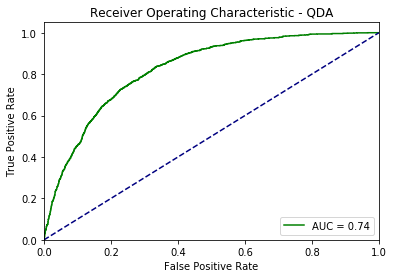

In [35]:
from sklearn.metrics import roc_curve, auc

qda_gen = QuadraticDiscriminantAnalysis(reg_param=best_c_qda)

qda_gen.fit(X,y)

y_pred = qda_gen.predict_proba(X)
y_pred_actual = qda_gen.predict(X)

res = roc_curve(y,y_pred[:,1], drop_intermediate=False)
roc_auc = roc_auc_score(y,y_pred_actual)

plt.figure()
plt.plot(res[0], res[1], color='green',
        label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - QDA')
plt.legend(loc="lower right")
plt.show()



After analyzing the training data and the corresponding ROC curve, we will now run the final component of our modelling, actual assessment on the test set.

# Applying QDA Model to Test Data

In [36]:
qda_gen = QuadraticDiscriminantAnalysis(reg_param=best_c_qda)
qda_gen.fit(X, y)
qda_test_error_score = qda_gen.score(X_test, y_test)
y_pred = qda_gen.predict(X_test)
qda_test_f1_score = f1_score(y_test,y_pred)
qda_test_auc_score = roc_auc_score(y_test,y_pred)
    
print("Test Accuracy Score on QDA: %0.3f" % qda_test_error_score)
print("Test F1 Score on QDA: %0.3f" % qda_test_f1_score)
print("Test ROC-AUC Score on QDA: %0.3f" % np.mean(ra_qda))

Test Accuracy Score on QDA: 0.799
Test F1 Score on QDA: 0.653
Test ROC-AUC Score on QDA: 0.734


With a strong F1 Score and ROC area under curve score, the QDA performance has been benchmarked as the best prediction model currently available